In [ ]:
!pip install cobra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 41.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cobra
from cobra.io import read_sbml_model
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import deque
import warnings

warnings.filterwarnings("ignore")

In [ ]:
dummy_model = read_sbml_model("iCHO2291.xml")
media = [rxn for rxn, bound in dummy_model.medium.items() if bound != 1000]

In [ ]:
max_biomass = dummy_model.optimize()["biomass_cho"]

In [ ]:
max_biomass

0.03236891404823238

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions, activation=nn.LeakyReLU, action_bound=(-10, 0)):
        super().__init__()
        self.n_actions = n_actions
        self.action_bound = action_bound

        self.model = nn.Sequential(
            nn.Linear(state_dim, 128),
            activation(),
            nn.LayerNorm(128),
            nn.Linear(128, 128),
            activation(),
            nn.Linear(128, n_actions)
        )

        self.logstds = nn.Parameter(torch.full((n_actions,), -1.0))

    def forward(self, X):
        means = self.model(X)
        scaled_means = torch.tanh(means)
        lower_bound, upper_bound = self.action_bound
        scaled_means = lower_bound + (upper_bound - lower_bound) * (scaled_means + 1) / 2

        stds = torch.clamp(self.logstds.exp(), 1e-2, 1.0)

        return torch.distributions.Normal(scaled_means, stds)

In [ ]:
class Critic(nn.Module):
    def __init__(self, state_dim, activation=nn.LeakyReLU):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128),
            activation(),
            nn.LayerNorm(128),
            nn.Linear(128, 128),
            activation(),
            nn.Linear(128, 1)
        )

    def forward(self, X):
        return self.model(X)

In [ ]:
class Environment:

    def __init__(self, model, objective, media, max_biomass):

        self.model = model
        self.objective = objective
        self.model.objective = self.objective
        self.model.reactions.get_by_id("biomass_cho").upper_bound = max_biomass
        self.model.reactions.get_by_id("biomass_cho").lower_bound = max_biomass
        self.media = media

    def get_current_bounds(self):
        return [self.model.reactions.get_by_id(rxn).lower_bound for rxn in self.media]

    def update_uptake(self, action):
        for rxn, update in zip(self.media, action):
            if self.model.reactions.get_by_id(rxn).lower_bound + update >= self.model.reactions.get_by_id(
                    rxn).upper_bound + update:
                self.model.reactions.get_by_id(rxn).upper_bound += update
                self.model.reactions.get_by_id(rxn).lower_bound += update
            else:
                self.model.reactions.get_by_id(rxn).lower_bound += update
                self.model.reactions.get_by_id(rxn).upper_bound += update

    def optimize(self):
        return self.model.optimize()[self.objective]

    def step(self, action):
        self.update_uptake(action)
        reward = self.optimize()
        next_state = self.get_current_bounds()
        return next_state, reward

    def get_current_fluxes(self):
        sol = self.model.optimize()
        return {x: sol[x] for x in ["biomass_cho", "igg_formation", "igg_hc", "igg_lc", "DM_igg[g]"]}

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)

In [ ]:
model = read_sbml_model("iCHO2291.xml")
#objective = "igg_formation"
#objective = "igg_hc"
#objective = "igg_lc"
objective = "DM_igg[g]"

env = Environment(model, objective, media, max_biomass)

state_dim = len(env.get_current_bounds())
n_actions = state_dim

actor = Actor(state_dim=state_dim, n_actions=n_actions, action_bound=(-1, 0.05))
critic = Critic(state_dim)
replay_buffer = ReplayBuffer(capacity=10000)
batch_size = 64
num_episodes = 20
max_steps = 20
history = []

optimizer_actor = torch.optim.Adam(actor.parameters(), lr=5e-5)
optimizer_critic = torch.optim.Adam(critic.parameters(), lr=5e-5)

trust_region_delta = 0.3
gamma = 0.99
c = 2.0
patience = 20
done = False

for episode in range(num_episodes):

    if done:
        final_media = [item[0] for item in history][-patience]
        final_reward = [item[2] for item in history][-patience]
        print("Converged in Episode: ", episode)
        print(f"Final Reward: {final_reward}")
        break

    state = torch.tensor(env.get_current_bounds(), dtype=torch.float32)

    for step in range(max_steps):
        action_distribution = actor(state)
        action = action_distribution.sample()

        next_state, reward = env.step(action.detach().numpy())  # Get the next state and reward from GSMM

        print(
            f"Episode: {episode}, Step: {step}, {objective} Flux: {reward}, Mean State: {state.mean().item()}, Key Fluxes: {env.get_current_fluxes()}")
        history.append((state.tolist(), action.tolist(), reward))

        reward_history = [item[2] for item in history][-patience:]
        if len(set(np.round(reward_history, 8))) == 1 and len(reward_history) == patience:
            done = True
            break

        reward = torch.tensor(reward, dtype=torch.float32)

        replay_buffer.add((state, action, reward, torch.tensor(next_state, dtype=torch.float32)))

        state = torch.tensor(next_state, dtype=torch.float32)

        if replay_buffer.size() >= batch_size:
            batch = replay_buffer.sample(batch_size)

            states, actions, rewards, next_states = zip(*batch)

            states = torch.stack(states)
            actions = torch.stack(actions)
            rewards = torch.tensor(rewards, dtype=torch.float32)
            next_states = torch.stack(next_states)

            values = critic(states).squeeze()
            action_log_probs = actor(states).log_prob(actions).sum(dim=1)

            with torch.no_grad():
                next_values = critic(next_states).squeeze()
                retrace_Q_values = rewards + gamma * next_values

            critic_loss = F.mse_loss(values, retrace_Q_values)

            optimizer_critic.zero_grad()
            critic_loss.backward()
            optimizer_critic.step()

            with torch.no_grad():
                old_action_log_probs = actor(states).log_prob(actions).sum(dim=1)

            IS_ratio = torch.exp(action_log_probs - old_action_log_probs).clamp(0, c)

            advantages = (retrace_Q_values - values).detach()

            actor_loss = -(IS_ratio * action_log_probs * advantages).mean()

            optimizer_actor.zero_grad()
            actor_loss.backward()
            optimizer_actor.step()

Episode: 0, Step: 0, DM_igg[g] Flux: 0.0, Mean State: -0.1455991119146347, Key Fluxes: {'biomass_cho': 0.03236891404823238, 'igg_formation': 0.0, 'igg_hc': 0.0, 'igg_lc': 0.0, 'DM_igg[g]': 0.0}
Episode: 0, Step: 1, DM_igg[g] Flux: 0.0, Mean State: -0.45222988724708557, Key Fluxes: {'biomass_cho': 0.03236891404823238, 'igg_formation': 0.0, 'igg_hc': 0.0, 'igg_lc': 0.0, 'DM_igg[g]': 0.0}
Episode: 0, Step: 2, DM_igg[g] Flux: 0.0, Mean State: -0.8029313683509827, Key Fluxes: {'biomass_cho': 0.03236891404823238, 'igg_formation': 0.0, 'igg_hc': 0.0, 'igg_lc': 0.0, 'DM_igg[g]': 0.0}
Episode: 0, Step: 3, DM_igg[g] Flux: 0.0008914841293247059, Mean State: -1.2097655534744263, Key Fluxes: {'biomass_cho': 0.03236891404823238, 'igg_formation': 0.0008914841293247057, 'igg_hc': 0.0017829682586494114, 'igg_lc': 0.0017829682586494114, 'DM_igg[g]': 0.0008914841293247058}
Episode: 0, Step: 4, DM_igg[g] Flux: 0.0017679598343655315, Mean State: -1.592092752456665, Key Fluxes: {'biomass_cho': 0.03236891404

In [ ]:
for reaction in list(dummy_model.medium.keys()):
    dummy_model.reactions.get_by_id(reaction).lower_bound = -1000
    dummy_model.reactions.get_by_id(reaction).upper_bound = 1000

dummy_model.reactions.get_by_id("biomass_cho").lower_bound = max_biomass
dummy_model.reactions.get_by_id("biomass_cho").upper_bound = max_biomass

dummy_model.objective = objective
optimal_flux = dummy_model.optimize()[objective]

In [ ]:
optimal_flux

0.05005005005005004

In [ ]:
state_history = [item[0] for item in history]
action_history = [item[1] for item in history]
reward_history = [item[2] for item in history]

In [ ]:
percent_optimal = [100*item/optimal_flux for item in reward_history]

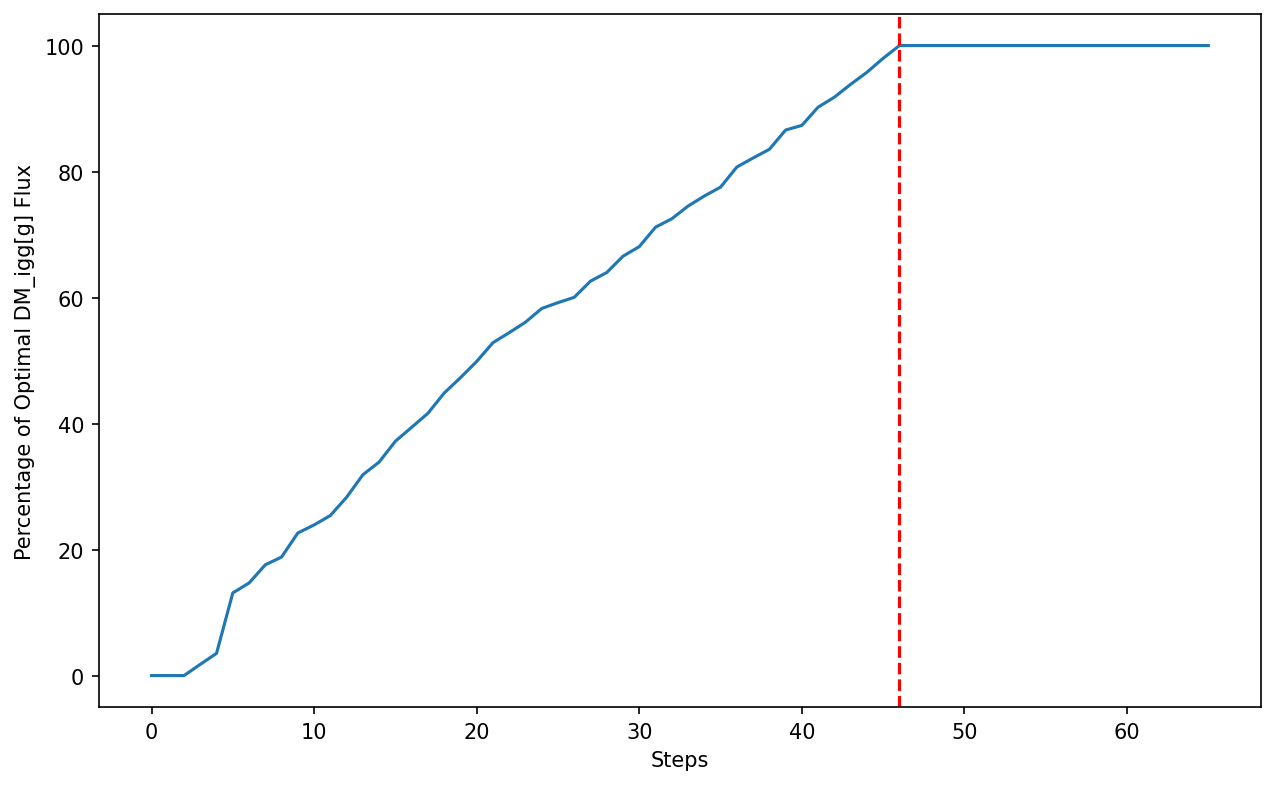

In [ ]:
plt.figure(figsize=(10, 6),dpi=150)
plt.plot(percent_optimal)
plt.axvline(x=len(state_history) - patience, color='r', linestyle='--')
plt.xlabel("Steps")
plt.ylabel(f"Percentage of Optimal {objective} Flux")
plt.show()

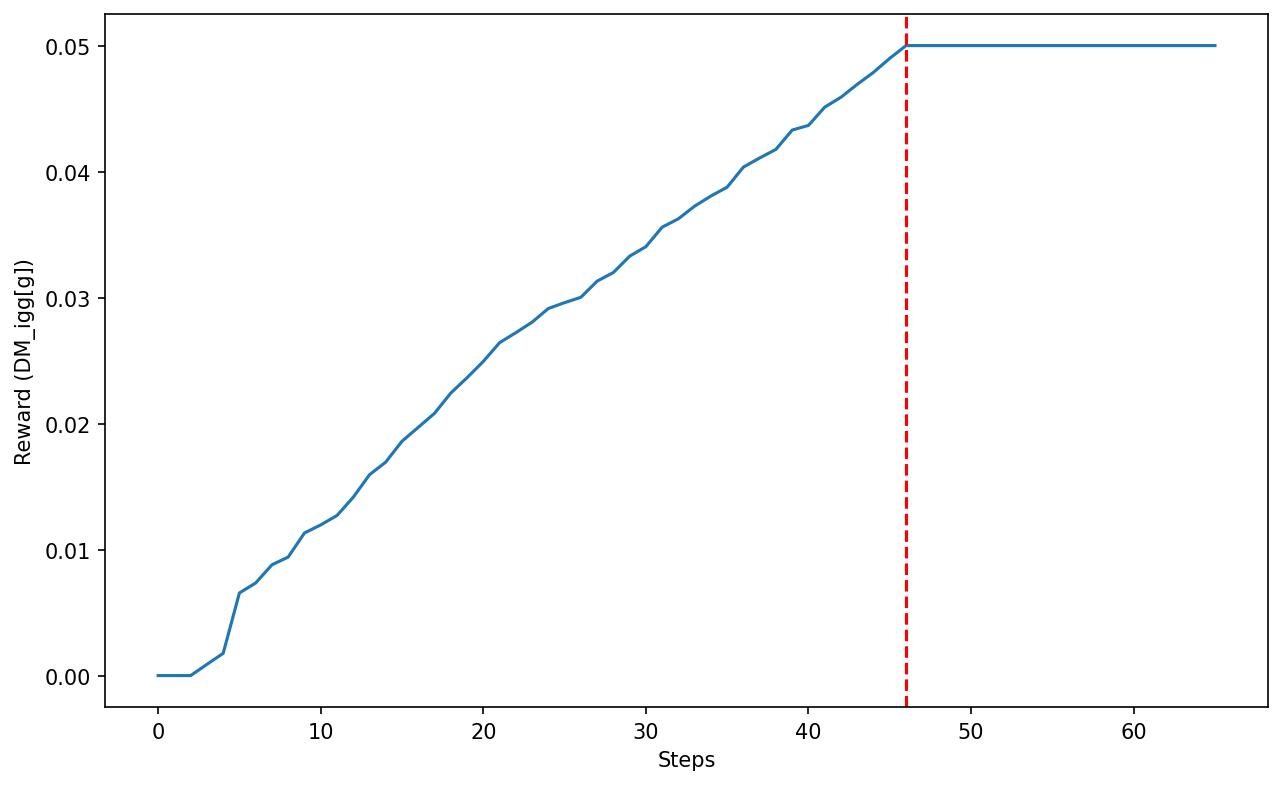

In [ ]:
plt.figure(figsize=(10, 6),dpi=150)
plt.plot(reward_history)
plt.axvline(x=len(state_history) - patience, color='r', linestyle='--')
plt.xlabel("Steps")
plt.ylabel(f"Reward ({objective})")
plt.show()

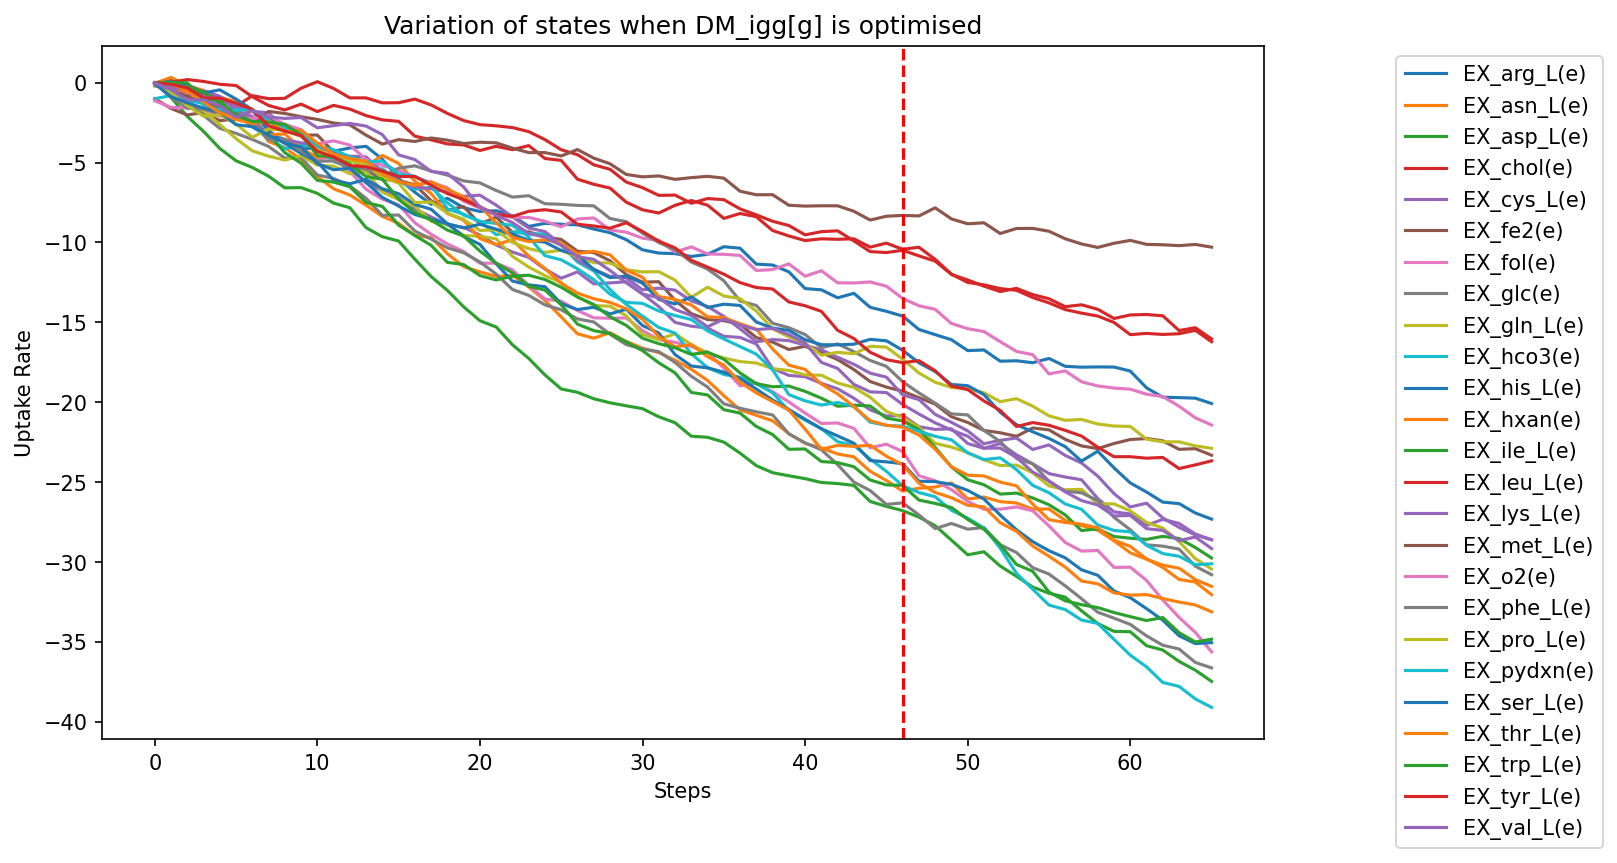

In [ ]:
plt.figure(figsize=(10, 6),dpi=150)
plt.plot(state_history, label=media)
plt.axvline(x=len(state_history) - patience, color='r', linestyle='--')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.title(f"Variation of states when {objective} is optimised")
plt.ylabel("Uptake Rate")
plt.xlabel("Steps")
plt.show()

In [ ]:
media_dict = {media[i]:final_media[i] for i in range(len(media))}
media_df = pd.DataFrame([media_dict]).transpose()
media_df.columns = ["Uptake Rate"]

In [ ]:
media_df

,Uptake Rate
EX_arg_L(e),-14.608187
EX_asn_L(e),-25.566427
EX_asp_L(e),-26.788074
EX_chol(e),-10.485641
EX_cys_L(e),-20.822445
EX_fe2(e),-19.309753
EX_fol(e),-23.085989
EX_glc(e),-26.297068
EX_gln_L(e),-20.957247
EX_hco3(e),-25.228952




---



In [ ]:
all_media_df = pd.read_csv("Final Media.csv")

In [ ]:
all_media_df.set_index("Exchange Rxn", inplace=True)

In [ ]:
all_media_df.std(axis = 1).sort_values(ascending = True)

,0
Exchange Rxn,
EX_lys_L(e),0.621563
EX_thr_L(e),1.101141
EX_fe2(e),2.302491
EX_tyr_L(e),2.918174
EX_val_L(e),3.035793
EX_ser_L(e),3.478751
EX_his_L(e),3.675637
EX_glc(e),3.769758
EX_o2(e),4.251276


In [ ]:
all_media_df = all_media_df.T

In [ ]:
all_media_df.head()

Exchange Rxn,EX_met_L(e),EX_leu_L(e),EX_chol(e),EX_o2(e),EX_arg_L(e),EX_ser_L(e),EX_pro_L(e),EX_tyr_L(e),EX_phe_L(e),EX_fe2(e),...,EX_pydxn(e),EX_thr_L(e),EX_fol(e),EX_his_L(e),EX_hxan(e),EX_trp_L(e),EX_hco3(e),EX_asn_L(e),EX_glc(e),EX_asp_L(e)
igg_formation,-21.554831,-20.135204,-23.069504,-22.034657,-18.585049,-18.666121,-25.579630,-18.477430,-11.510303,-19.999634,...,-15.632512,-23.185907,-20.844687,-17.427767,-9.226537,-13.880227,-17.291866,-20.452467,-18.659273,-13.673279
igg_hc,-16.850582,-20.469276,-21.444288,-22.272850,-9.338561,-18.006762,-17.067551,-11.869904,-16.452965,-17.842939,...,-26.116415,-23.695349,-30.008846,-15.319766,-18.628391,-16.743225,-27.429775,-11.709015,-19.624519,-22.820623
igg_lc,-21.000320,-15.819118,-15.258899,-21.667707,-22.911242,-11.033723,-13.804248,-15.723824,-27.799875,-14.811574,...,-18.432978,-21.572752,-13.436712,-20.052357,-13.513494,-20.404503,-25.398388,-25.067776,-18.253548,-19.157429
DM_igg[g],-8.304737,-10.426083,-10.485641,-13.503771,-14.608187,-16.746494,-17.306963,-17.522146,-18.716042,-19.309753,...,-21.496778,-21.562723,-23.085989,-23.848989,-23.916117,-25.206406,-25.228952,-25.566427,-26.297068,-26.788074


In [ ]:
Rate= all_media_df.reset_index()
Rate

Exchange Rxn,index,EX_met_L(e),EX_leu_L(e),EX_chol(e),EX_o2(e),EX_arg_L(e),EX_ser_L(e),EX_pro_L(e),EX_tyr_L(e),EX_phe_L(e),...,EX_pydxn(e),EX_thr_L(e),EX_fol(e),EX_his_L(e),EX_hxan(e),EX_trp_L(e),EX_hco3(e),EX_asn_L(e),EX_glc(e),EX_asp_L(e)
0,igg_formation,-21.554831,-20.135204,-23.069504,-22.034657,-18.585049,-18.666121,-25.579630,-18.477430,-11.510303,...,-15.632512,-23.185907,-20.844687,-17.427767,-9.226537,-13.880227,-17.291866,-20.452467,-18.659273,-13.673279
1,igg_hc,-16.850582,-20.469276,-21.444288,-22.272850,-9.338561,-18.006762,-17.067551,-11.869904,-16.452965,...,-26.116415,-23.695349,-30.008846,-15.319766,-18.628391,-16.743225,-27.429775,-11.709015,-19.624519,-22.820623
2,igg_lc,-21.000320,-15.819118,-15.258899,-21.667707,-22.911242,-11.033723,-13.804248,-15.723824,-27.799875,...,-18.432978,-21.572752,-13.436712,-20.052357,-13.513494,-20.404503,-25.398388,-25.067776,-18.253548,-19.157429
3,DM_igg[g],-8.304737,-10.426083,-10.485641,-13.503771,-14.608187,-16.746494,-17.306963,-17.522146,-18.716042,...,-21.496778,-21.562723,-23.085989,-23.848989,-23.916117,-25.206406,-25.228952,-25.566427,-26.297068,-26.788074


In [ ]:
Rate_features = Rate.iloc[:,0]
Rate_features

,index
0,igg_formation
1,igg_hc
2,igg_lc
3,DM_igg[g]


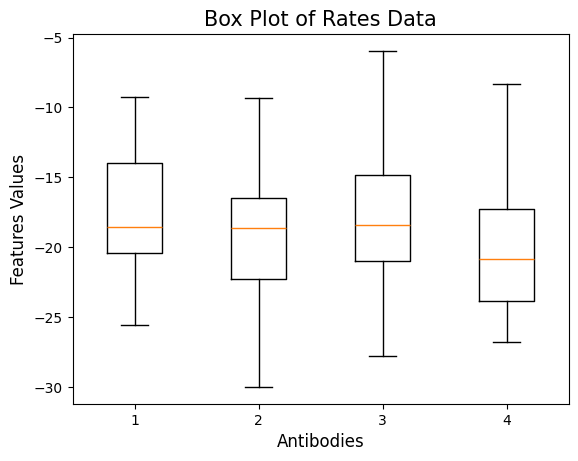

In [ ]:
plt.boxplot(Rate.iloc[:,1:].T)
plt.title("Box Plot of Rates Data",size = 15)
plt.xlabel('Antibodies',size = 12)
plt.ylabel('Features Values',size = 12)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_media = scaler.fit_transform(all_media_df)

In [ ]:
from sklearn.decomposition import PCA
rate_pca = PCA()
pca_media = rate_pca.fit_transform(scaled_media)

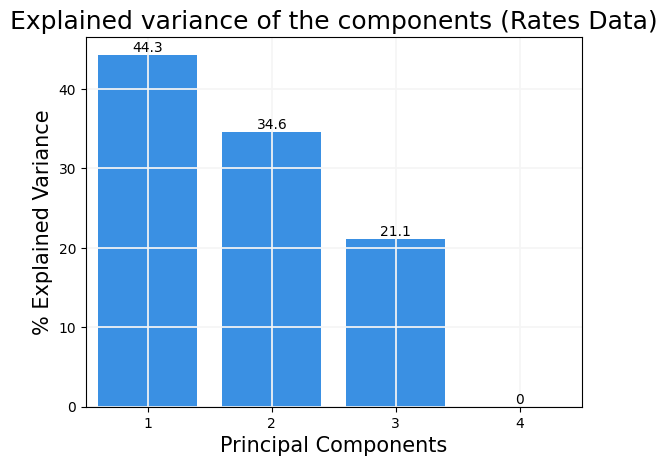

In [ ]:
ax = sns.barplot(y = np.round(rate_pca.explained_variance_ratio_*100,1),
              x = [f'{i+1}' for i in range(4)],color='dodgerblue')

ax.bar_label(ax.containers[0], fontsize=10);
plt.title('Explained variance of the components (Rates Data)', size=18)
plt.xlabel('Principal Components', size=15)
plt.ylabel('% Explained Variance', size=15)
plt.grid(True,color='whitesmoke',linewidth = 1.25)

In [ ]:
transformed_Rate_sample_data=pd.DataFrame(data=pca_media,columns=[f'Principal Component {i+1}' for i in range(4)])
transformed_Rate_sample_data

,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4
0,4.412891,-0.095214,-2.556577,8.293502e-16
1,0.869974,-3.464544,2.852511,8.293502e-16
2,-0.391377,4.632496,1.633898,8.293502e-16
3,-4.891489,-1.072738,-1.929832,8.293502e-16


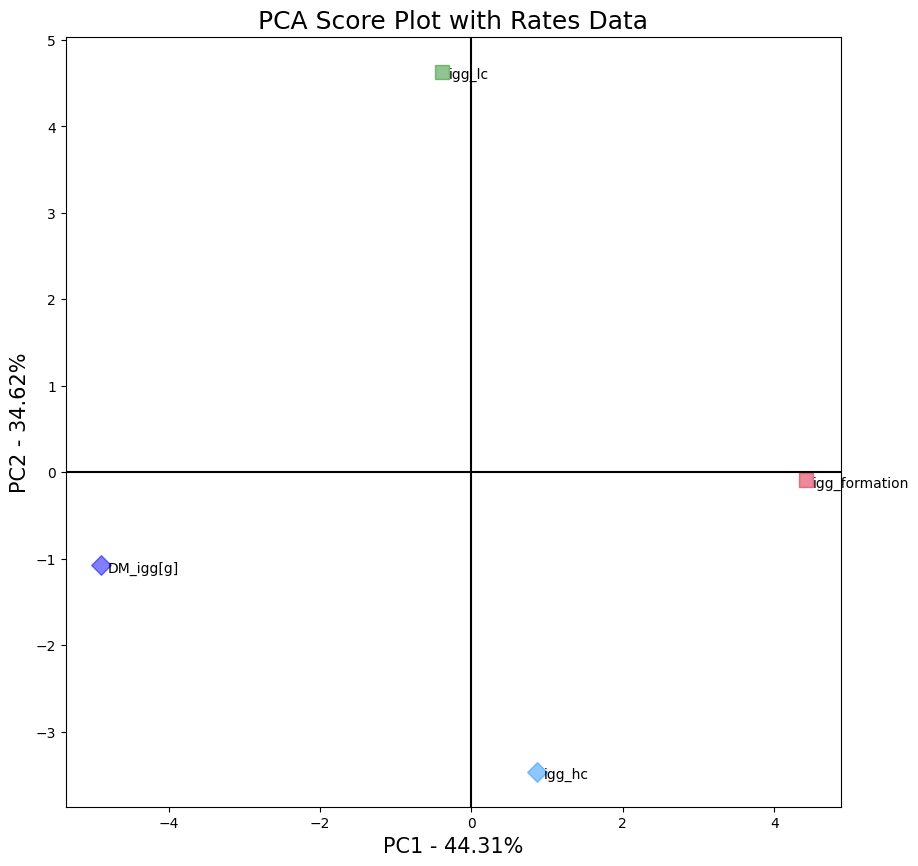

In [ ]:

plot_dict = {0: ("igg_formation","s","crimson"),
             1: ("igg_hc","D","dodgerblue"),
             2: ("igg_lc","s","forestgreen"),
             3: ("DM_igg[g]","D","blue"),
            }

fig, ax = plt.subplots(figsize=(10,10))

# Scatter plot
for i in range(len(transformed_Rate_sample_data)):
    ax.scatter(x=transformed_Rate_sample_data.iloc[i,0],
                    y=transformed_Rate_sample_data.iloc[i,1],
                    marker=plot_dict[i][1],
                    label=plot_dict[i][0],
                    color=plot_dict[i][2],
                    alpha=0.5,
                    s=100)
    plt.annotate(plot_dict[i][0], xy=(transformed_Rate_sample_data.iloc[i,0], transformed_Rate_sample_data.iloc[i,1]), xytext=(5, -5), textcoords='offset points')

plt.axhline(y=0, color='black', linestyle='-')
plt.axvline(x=0, color='black', linestyle='-')
ax.set_xlabel(f"PC1 - {rate_pca.explained_variance_ratio_[0]*100:.2f}%",size = 15)
ax.set_ylabel(f"PC2 - {rate_pca.explained_variance_ratio_[1]*100:.2f}%",size = 15)
ax.set_title("PCA Score Plot with Rates Data", size = 18)
plt.show()

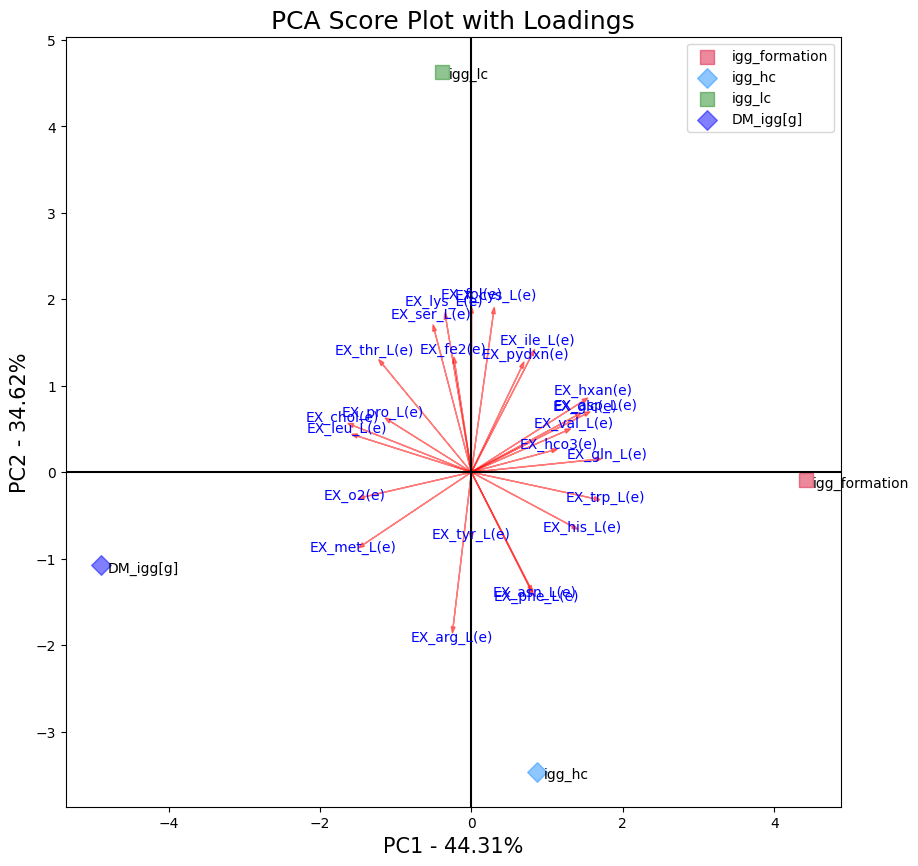

In [ ]:
plot_dict = {0: ("igg_formation","s","crimson"),
             1: ("igg_hc","D","dodgerblue"),
             2: ("igg_lc","s","forestgreen"),
             3: ("DM_igg[g]","D","blue"),
            }

fig, ax = plt.subplots(figsize=(10, 10))

for i in range(len(transformed_Rate_sample_data)):
    ax.scatter(x=transformed_Rate_sample_data.iloc[i, 0],  # PC1
               y=transformed_Rate_sample_data.iloc[i, 1],  # PC2
               marker=plot_dict[i][1],
               label=plot_dict[i][0],
               color=plot_dict[i][2],
               alpha=0.5,
               s=100)

    ax.annotate(plot_dict[i][0],
                xy=(transformed_Rate_sample_data.iloc[i, 0], transformed_Rate_sample_data.iloc[i, 1]),
                xytext=(5, -5),
                textcoords='offset points')


plt.axhline(y=0, color='black', linestyle='-')
plt.axvline(x=0, color='black', linestyle='-')


ax.set_xlabel(f"PC1 - {rate_pca.explained_variance_ratio_[0]*100:.2f}%", size=15)
ax.set_ylabel(f"PC2 - {rate_pca.explained_variance_ratio_[1]*100:.2f}%", size=15)
ax.set_title("PCA Score Plot with Loadings", size=18)

# Plot loadings as arrows
loadings = rate_pca.components_.T
for j, (pc1_loading, pc2_loading) in enumerate(zip(loadings[:, 0], loadings[:, 1])):
    ax.arrow(0, 0, pc1_loading * 5.5, pc2_loading *5.5, color='red', alpha=0.5, head_width=0.05)
    ax.text(pc1_loading *6, pc2_loading *6, all_media_df.columns[j] , color='blue', ha='center')

plt.legend()
plt.show()

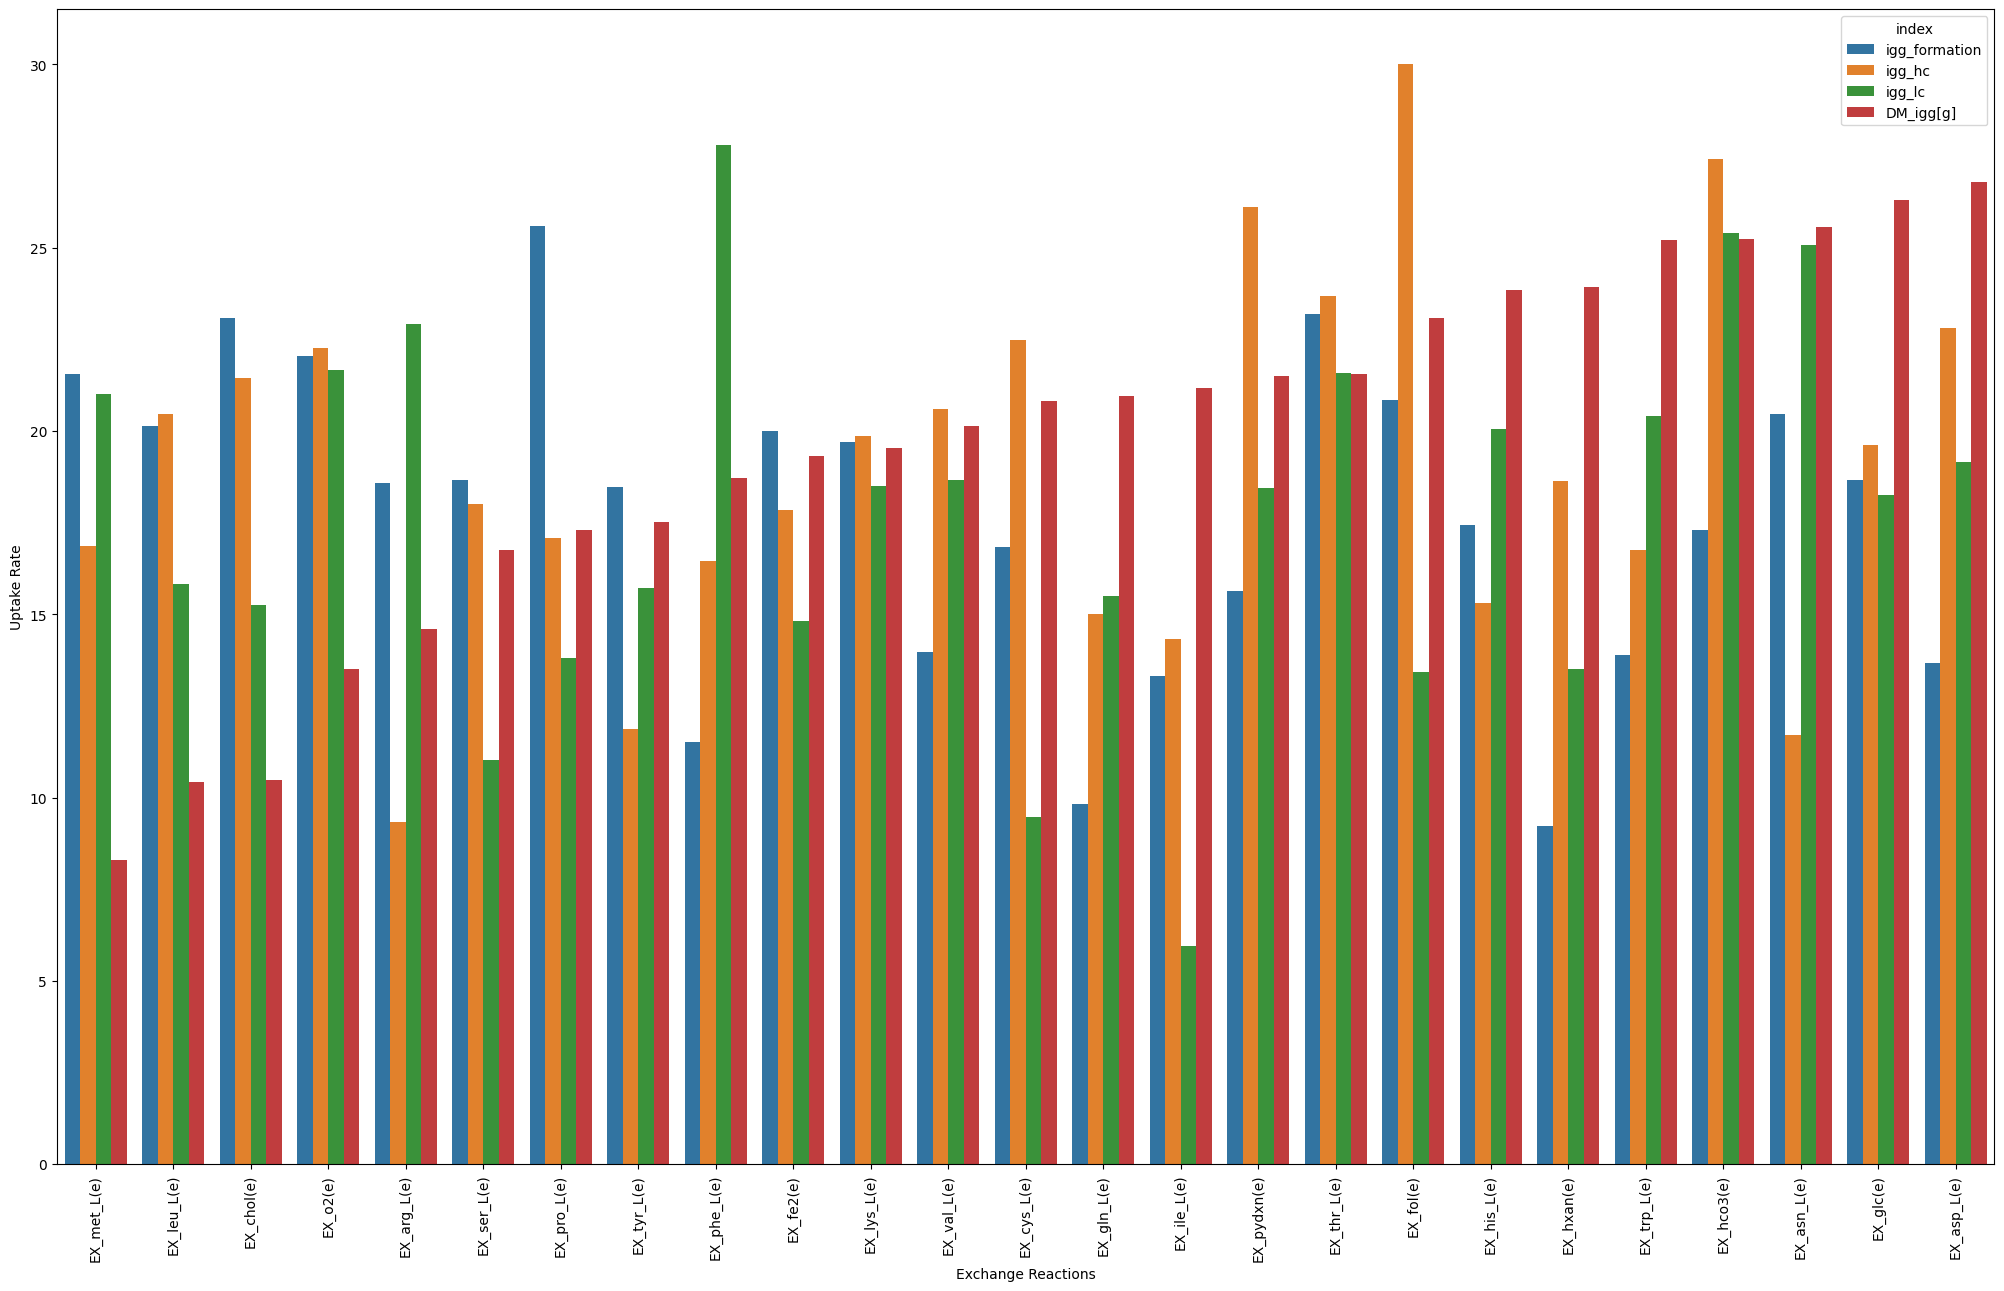

In [ ]:
plt.figure(figsize=(25,15))
melted_df = pd.melt(all_media_df.abs().reset_index(), id_vars=['index'], var_name='Exchange Reactions', value_name='Uptake Rate')
sns.barplot(x='Exchange Reactions', y='Uptake Rate', hue='index', data=melted_df)
plt.xticks(rotation=90);